# Playground with sampled data from KiT-RT

### Setup

In [179]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux
using Flux: onecold, @epochs

In [180]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, [1.0, 0.0], [0.0, 1.0])
    return x, y
end

function regime_number(Y, rg=1)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Y)
    Y1 = nn(X)

    YA1 = [onecold(Y1[:, i]) for i in axes(Y1, 2)]
    YA = [onecold(Y[:, i]) for i in axes(Y, 2)]

    accuracy = 0.0
    for i in eachindex(YA)
        if YA[i] == YA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(YA)

    return accuracy
end

accuracy (generic function with 1 method)

### Dataset

In [181]:
file = open("../../../data/1d/a3_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end];

In [182]:
file = open("../../../data/1d/a6_ev5.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]

file = open("../../../data/1d/a8_ev5.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]
nd = length(pdfs) ÷ 2

6003

In [183]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])

VelocitySpace1D{Float64,Int64,Vector{Float64},Vector{Float64}}
domain: (-5.0,5.0)
resolution: 100
ghost: 0


In [184]:
dist = Uniform(0.0001, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.000001, 1.0)
kns = rand(dist, nd);

In [185]:
X = zeros(7, nd)
Y = zeros(2, nd)
for i = 1:nd
    try
        #fL = pdfs[i]; fR = pdfs[nd*2-i]
        fL = pop!(pdfs); fR = pop!(pdfs) # shuffle
        wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
        #@show wL, wR
        w = @. (wL + wR) / 2
        sw = @. (wR - wL) / dxs[i]
        f = @. (fL + fR) / 2

        X[:, i], Y[:, i] = regime_data(w, sw, f, vs.u, 0, kns[i])
    catch
    end
end

In [186]:
regime_number(Y)

NS regime: 613 of 6003


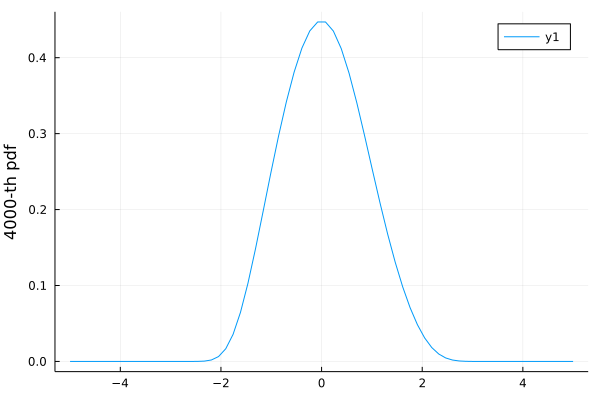

In [187]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Model

In [188]:
@load "../nn.jld2" nn

1-element Vector{Symbol}:
 :nn

In [189]:
accuracy(nn, X, Y)

0.8670664667666167

In [190]:
data = Flux.Data.DataLoader((X, Y), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
loss(x, y) = sum(abs2, nn(x) - y) / size(x, 2) #+ 1e-6 * sum(sqnorm, ps)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [193]:
@epochs 50 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

loss: 0.12931036980230948


┌ Info: Epoch 1
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.13179975673165334


┌ Info: Epoch 2
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1205669624379211


┌ Info: Epoch 3
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1366726354873618


┌ Info: Epoch 4
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11970069244626544


┌ Info: Epoch 5
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12515433563358005


┌ Info: Epoch 6
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12311641730003849


┌ Info: Epoch 7
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11969960746644635


┌ Info: Epoch 8
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12325444285130684


┌ Info: Epoch 9
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.13203034772836314


┌ Info: Epoch 10
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11664005426084256


┌ Info: Epoch 11
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.15061156888229127


┌ Info: Epoch 12
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20886346269924694


┌ Info: Epoch 13
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12892240900087512


┌ Info: Epoch 14
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11802782396533003


┌ Info: Epoch 15
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.13239848885429356


┌ Info: Epoch 16
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11670046325449528


┌ Info: Epoch 17
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11650080014073436


┌ Info: Epoch 18
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12261992393544896


┌ Info: Epoch 19
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12331896691964847


┌ Info: Epoch 20
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11011432291264839


┌ Info: Epoch 21
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11857863203428592


┌ Info: Epoch 22
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11548667571709158


┌ Info: Epoch 23
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11608542880406135


┌ Info: Epoch 24
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11489516336734605


┌ Info: Epoch 25
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11934551672998499


┌ Info: Epoch 26
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11252260359328298


┌ Info: Epoch 27
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1141032603891342


┌ Info: Epoch 28
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12512166386017773


┌ Info: Epoch 29
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11700754348276965


┌ Info: Epoch 30
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11795501024032817


┌ Info: Epoch 31
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10866667048348266


┌ Info: Epoch 32
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10919739230216778


┌ Info: Epoch 33
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10875723724823061


┌ Info: Epoch 34
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10887067431426765


┌ Info: Epoch 35
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10985178736181882


┌ Info: Epoch 36
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10875690850144001


┌ Info: Epoch 37
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11107354459994412


┌ Info: Epoch 38
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11285010924317354


┌ Info: Epoch 39
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.14246143762823965


┌ Info: Epoch 40
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11020173917192111


┌ Info: Epoch 41
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11646658341732256


┌ Info: Epoch 42
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1131517107990177


┌ Info: Epoch 43
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10512371382286775


┌ Info: Epoch 44
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10583242307999358


┌ Info: Epoch 45
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11669767673152724


┌ Info: Epoch 46
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10648971218900084


┌ Info: Epoch 47
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1064954472916278


┌ Info: Epoch 48
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10388963254368724


┌ Info: Epoch 49
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10291218705618696


┌ Info: Epoch 50
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


In [195]:
cd(@__DIR__)
@save "nn_rif.jld2" nn # reinforcement neural model

### Test

In [194]:
accuracy(nn, X, Y)

0.9333666500083292